<a href="https://colab.research.google.com/github/teoad95/Sport-analytics/blob/main/Football_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Football analytics using AI techniques</h1>
<p> </p>

In [40]:
import cv2
import torch
import pandas as pd
import numpy as np
import time
import os
from PIL import Image

In [4]:
%matplotlib inline

In [5]:
!git clone https://github.com/teoad95/Sport-analytics/

Cloning into 'Sport-analytics'...
remote: Enumerating objects: 126, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 126 (delta 17), reused 7 (delta 2), pack-reused 91
Receiving objects: 100% (126/126), 119.62 MiB | 35.66 MiB/s, done.
Resolving deltas: 100% (62/62), done.


In [6]:
os.rename('/content/Sport-analytics', 'SportAnalytics')

'SportAnalytics'

In [7]:
pip install pytube

     |████████████████████████████████| 61kB 3.5MB/s 


In [79]:
pip install YOLO

     |████████████████████████████████| 61kB 3.3MB/s 
     |████████████████████████████████| 112kB 9.3MB/s 
     |████████████████████████████████| 7.7MB 33.1MB/s 
     |████████████████████████████████| 133kB 44.3MB/s 
     |████████████████████████████████| 122kB 39.8MB/s 
     |████████████████████████████████| 3.6MB 33.6MB/s 
     |████████████████████████████████| 552kB 33.0MB/s 
     |████████████████████████████████| 143kB 45.0MB/s 
     |████████████████████████████████| 81kB 7.2MB/s 
     |████████████████████████████████| 71kB 7.2MB/s 
     |████████████████████████████████| 552kB 31.6MB/s 
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.6 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Found existing instal

##1 Generate dataset
For dataset generation (frame pictures) we created a function which given a youtube link, downloads the video and split it into frames every 0.5 sec.

In [8]:
from SportAnalytics.util_funs import get_frames_from_youtube_video
get_frames_from_youtube_video('https://www.youtube.com/watch?v=TeTQO5DgOXI')

Downloaded /content/Videos/Highlights Real Madrid vs FC Barcelona (2-1).mp4, in location Videos correctly!


In [21]:
image_location = '/content/SportAnalytics/Images/frame53.jpg'

##2 Detect players
For this task we used the pre-trained YOLO neural network.

In [10]:
# Load model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /root/.cache/torch/hub/master.zip


requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...


YOLOv5 🚀 2021-7-7 torch 1.9.0+cu102 CPU



  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13

requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



Fusing layers... 


Model Summary: 224 layers, 7266973 parameters, 0 gradients
Adding AutoShape... 


In [22]:
img = cv2.imread(image_location, cv2.IMREAD_COLOR)

In [17]:
def plot_image(image):
  %matplotlib inline
  from matplotlib import pyplot as plt
  plt.figure(figsize=(10,30))
  plt.imshow(image)
  plt.axis('off')
  plt.show()

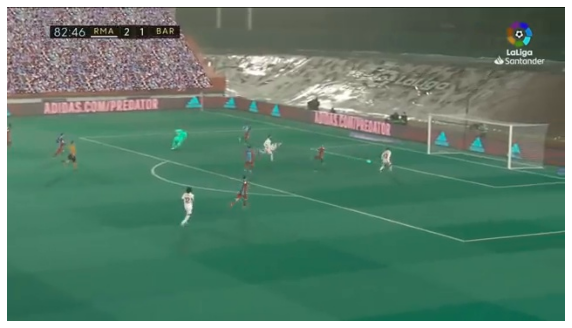

In [23]:
plot_image(img)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


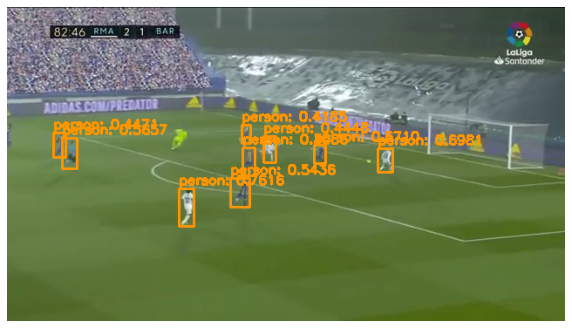

--- 0.77 seconds ---


In [24]:
from SportAnalytics.util_funs import plot_bb_on_img
import matplotlib.pyplot as plt

start_time = time.time()

# inference
results = model(img, size=640)  # includes NMS
boxes = results.pandas().xyxy[0]

# plot bounding boxes
cv2_img_bb = plot_bb_on_img(img, boxes, tolerance=0.3)
cv2_img_bb = cv2.cvtColor(cv2_img_bb, cv2.COLOR_BGR2RGB)

plot_image(cv2_img_bb[:,:,::-1])

# cv2.imshow("frame", cv2_img_bb)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

print("--- %.2f seconds ---" % (time.time() - start_time))

In [25]:
img = Image.open(image_location)

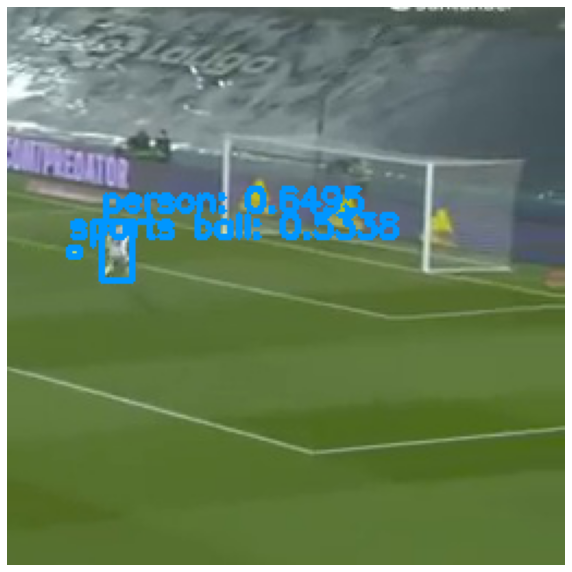

--- 0.42 seconds ---


In [29]:
from PIL import Image
from SportAnalytics.util_funs import sliding_window, keep_unique_objects_df
import math


fig = plt.figure(figsize=(25, 25))

#img = Image.open(image_location)
img_width, img_height = img.size
step_size= 64
window_size = (256,256)

columns = math.ceil(int(img_width / step_size))-3
rows = math.ceil(img_height / step_size)

ax = []

boxes_df = pd.DataFrame(columns = ['xmin','ymin','xmax','ymax','confidence','class','name','centerx','centery'])

start_time = time.time()

for i,(box,img) in enumerate(sliding_window(img, step_size, window_size)):
    ax.append(fig.add_subplot(rows, columns, i+1))
    # inference
    
    results = model(img, size=320)  # includes NMS
    boxes = results.pandas().xyxy[0]
    
  
    # plot bounding boxes
    cv2_img_bb = plot_bb_on_img(img, boxes)
    cv2_img_bb = cv2.cvtColor(cv2_img_bb, cv2.COLOR_BGR2RGB)
    plot_image(cv2_img_bb)
    
    # project to starting image
    boxes.xmin = boxes.xmin+box[0]
    boxes.xmax = boxes.xmax+box[0]

    boxes.ymin = boxes.ymin+box[1]
    boxes.ymax = boxes.ymax+box[1]

    boxes['centerx'] = boxes.xmax - (boxes.xmax-boxes.xmin)/2
    boxes['centery'] = boxes.ymax - (boxes.ymax-boxes.ymin)/2
    boxes['distance'] = np.sqrt(boxes.centerx*boxes.centerx + boxes.centery*boxes.centery)
    
    boxes_df = boxes_df.append(boxes, ignore_index=True)
    
boxes_df = keep_unique_objects_df(boxes_df)

                
                
print("--- %.2f seconds ---" % (time.time() - start_time))

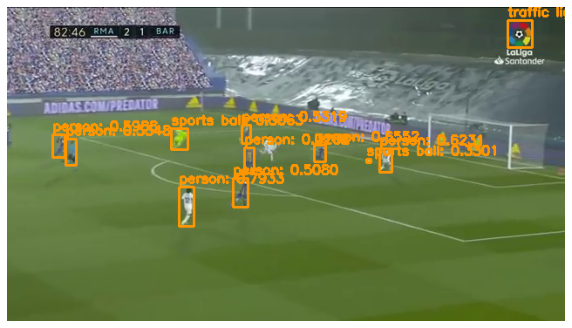

In [30]:
from SportAnalytics.util_funs import plot_bb_on_img, split_image_and_predict
import matplotlib.pyplot as plt

img = cv2.imread(image_location, cv2.IMREAD_COLOR)

boxes =  split_image_and_predict(img, model)

# plot bounding boxes
cv2_img_bb = plot_bb_on_img(img, boxes, tolerance=0.3)
cv2_img_bb = cv2.cvtColor(cv2_img_bb, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15,15))
plot_image(cv2_img_bb[:,:,::-1])

##3 Detect players and extract player object using RCNN

In [35]:
image_location2 = '/content/SportAnalytics/Images/frame24.jpg'

In [32]:
RED_COLOR = np.array([255, 0, 0]) 
BLACK_COLOR = np.array([255, 255, 255]) 

<p>Load weights and Mask-RCNN configuration</p>

In [34]:
weightsPath = "/content/SportAnalytics/network_configuration/frozen_inference_graph.pb"
configPath = "/content/SportAnalytics/network_configuration/mask_rcnn_inception_v2_coco_2018_01_28.pbtxt"
net = cv2.dnn.readNetFromTensorflow(weightsPath, configPath)

[INFO] image size: 640x360 pixels


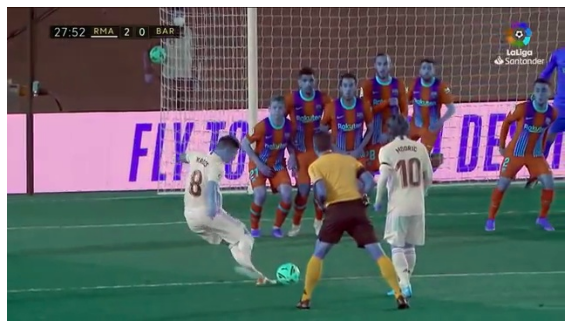

In [37]:
# load our input image and grab its spatial dimensions
image = cv2.imread(image_location2, cv2.IMREAD_UNCHANGED)
(H, W) = image.shape[:2]
print("[INFO] image size: {}x{} pixels".format(W, H))
plot_image(image)

In [41]:
# construct a blob from the input image and then perform a forward
# pass of the Mask R-CNN, giving us (1) the bounding box coordinates
# of the objects in the image along with (2) the pixel-wise segmentation
# for each specific object
blob = cv2.dnn.blobFromImage(image, swapRB=True, crop=False)
net.setInput(blob)
start = time.time()
(boxes, masks) = net.forward(["detection_out_final", "detection_masks"])
end = time.time()
# show timing information and volume information on Mask R-CNN
print("[INFO] Mask R-CNN took {:.6f} seconds".format(end - start))
print("[INFO] boxes shape: {}".format(boxes.shape))
print("[INFO] boxes size: {}".format(boxes.size))
print("[INFO] masks shape: {}".format(masks.shape))

[INFO] Mask R-CNN took 7.415890 seconds
[INFO] boxes shape: (1, 1, 100, 7)
[INFO] boxes size: 700
[INFO] masks shape: (100, 90, 15, 15)


In [53]:
players = []

In [51]:
def extract_players(image):
    height, width , _ = image.shape
    cv2_img_bb = np.array(image) 
    # Convert RGB to BGR 
    cv2_img_bb = cv2.cvtColor(cv2_img_bb, cv2.COLOR_BGR2RGB) 
    for i in range(boxes.shape[2]):
        box = boxes[0, 0 ,i]
        class_id = box[1]
        score = box[2]
        if (score < 0.5):
            continue
        # get box coordinates
        x = int(box[3] * width)
        y = int(box[4] * height)
        x2 = int(box[5] * width)
        y2 = int(box[6] * height)

        object_of_image = image[y: y2, x: x2]
        ooi_height, ooi_width, _ = object_of_image.shape

        # get the mask
        mask = masks[i, int(class_id)]
        mask = cv2.resize(mask, (ooi_width, ooi_height))
        _, mask = cv2.threshold(mask, 0.5, 255, cv2.THRESH_BINARY)

        # convert mask to proper type in order to perform the bitwise_and
        visMask = (mask * 255).astype("uint8")

        # extract from box only the object for classification
        final = cv2.bitwise_and(object_of_image, object_of_image, mask = visMask)
        players.append(final)
        cv2.rectangle(cv2_img_bb, (x,y), (x2,y2), (255, 0, 0), 3)

In [54]:
extract_players(cv2.imread(image_location2))

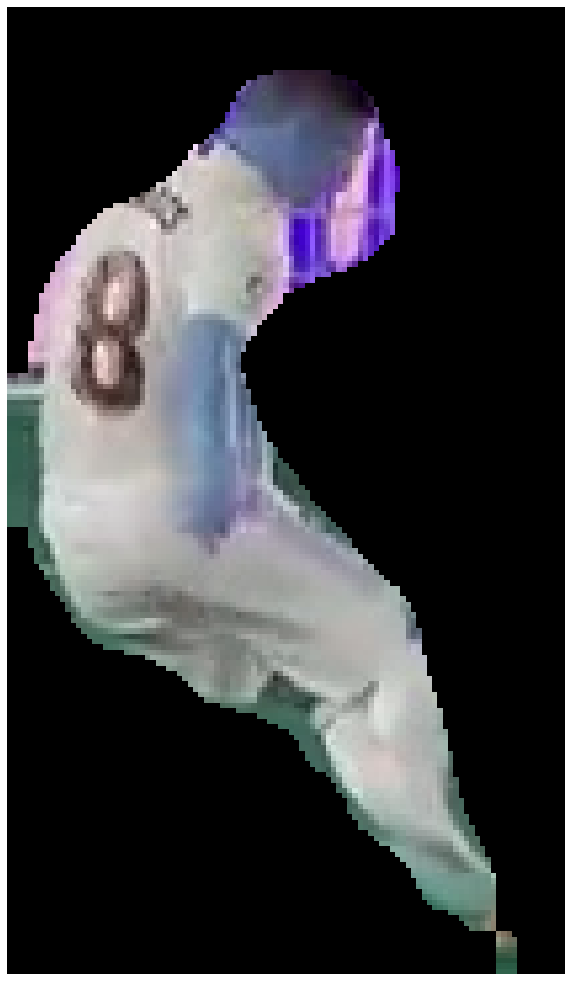

In [56]:
plot_image(players[2])

##4 Classify players per team

The typical way to to classify different person objects is by color.
For this task, kmeans will get used.
We'll find the average of the colors for each image and then we will cluster them in 2 centers.

In [60]:
image_location3 = '/content/SportAnalytics/Images/frame35.jpg'

In [63]:
cv2_img = cv2.imread(image_location3)

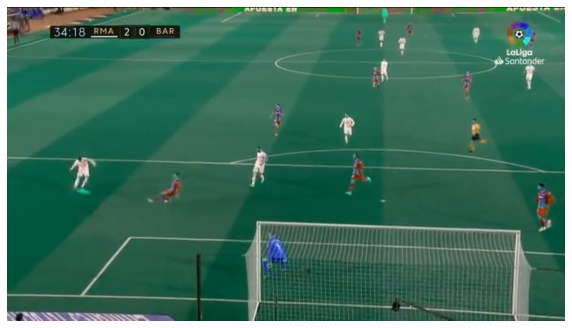

In [64]:
plot_image(cv2_img)

In [66]:
boxes =  split_image_and_predict(cv2_img, model)
# plot bounding boxes
cv2_img_bb = plot_bb_on_img(cv2_img, boxes, tolerance=0.3)

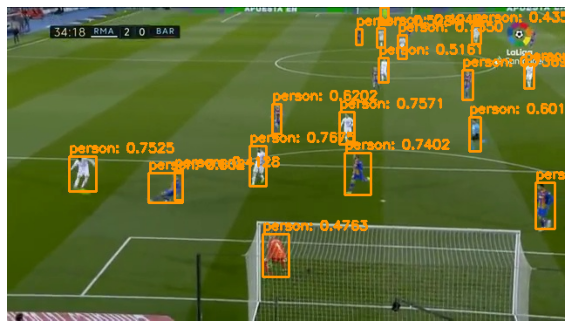

In [67]:
plot_image(cv2_img_bb)

In [62]:
def extract_average_color(img):
    # calculate the average color of each row of our image
    avg_color_per_row = np.average(img, axis=0)

    # calculate the averages of our rows
    avg_colors = np.average(avg_color_per_row, axis=0)
    # so, convert that array to integers
    int_averages = np.array(avg_colors, dtype=np.uint8)
    return int_averages

In [69]:
players = []

In [70]:
original_image = cv2.imread(image_location3)
boxes.assign(Name='image')
for i, b in boxes.iterrows():
    #boxes.insert(i, 'image', res_bgr[int(b['ymin']):int(b['ymax']), int(b['xmin']):int(b['xmax'])])
    players.append(original_image[int(b['ymin']):int(b['ymax']), int(b['xmin']):int(b['xmax'])])
boxes['image'] = players

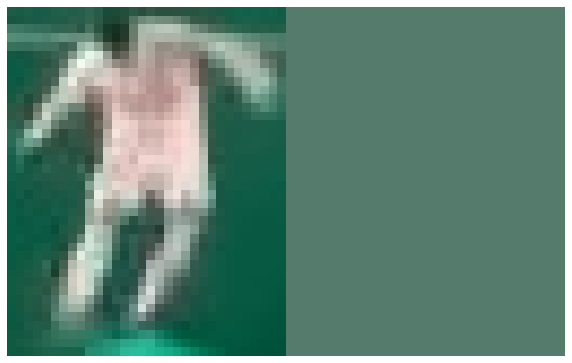

In [89]:
height, width, _ = np.shape(boxes['image'][1])
int_averages = extract_average_color(boxes['image'][1])
average_image = np.zeros((height, width, 3), np.uint8)
average_image[:] = int_averages
plot_image(np.hstack([boxes['image'][1], average_image]))

In [57]:
from sklearn.cluster import KMeans

In [71]:
features = [extract_average_color(b.image) for i,b in boxes.iterrows()]
clusters = KMeans(2, random_state= 40)
clustering_results = clusters.fit_predict(features)
boxes['team'] = clustering_results

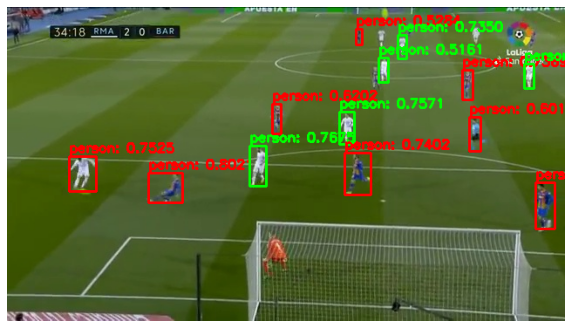

In [72]:
from SportAnalytics.util_funs import plot_bb_on_img_with_teams
cv2_img_bb = plot_bb_on_img_with_teams(original_image, boxes)
plot_image(cv2_img_bb)

##5 Detect player number
For this experiments we used an already trained and configured yolo network on SVHN dataset. Unfortunatelly the network did not generalize well and we couldnt extract any information from the images.

In [73]:
!git clone https://github.com/penny4860/Yolo-digit-detector

Cloning into 'Yolo-digit-detector'...
remote: Enumerating objects: 4287, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 4287 (delta 0), reused 0 (delta 0), pack-reused 4284
Receiving objects: 100% (4287/4287), 179.30 MiB | 32.14 MiB/s, done.
Resolving deltas: 100% (2862/2862), done.


In [91]:
import shutil
os.rename('/content/Yolo-digit-detector', 'YoloDigitDetector')
shutil.move('/content/YoloDigitDetector/yolo','/content/yolo')

'/content/yolo'

In [104]:
import json
import cv2
from yolo.backend.utils.box import draw_scaled_boxes

ModuleNotFoundError: ignored